In [1]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Q1

## Read 1.jpg image

In [2]:
#Read image and  convert from BGR to RGB
image1 = cv2.imread('images/1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

## Q1.1: RGB to CMYK & CMYK to RGB

In [3]:
def RGB_to_CMYK(r, g, b, RGB_SCALE=255, CMYK_SCALE=100):
    # Normalize the RGB values to the range [0, 1]
    r /= RGB_SCALE
    g /= RGB_SCALE
    b /= RGB_SCALE

    # Calculate the K (black) value
    k = 1 - max(r, g, b)

    if k == 1:
        # If K is 1, C, M, and Y are all zero (since it's completely black)
        c = 0
        m = 0
        y = 0
    else:
        # Calculate the CMY values
        c = (1 - r - k) / (1 - k)
        m = (1 - g - k) / (1 - k)
        y = (1 - b - k) / (1 - k)

    c = round(c * CMYK_SCALE, 2)
    m = round(m * CMYK_SCALE, 2)
    y = round(y * CMYK_SCALE, 2)
    k = round(k * CMYK_SCALE, 2)

    return c, m, y, k


In [4]:
def CMYK_to_RGB(c, m, y, k, RGB_SCALE=255, CMYK_SCALE=100):
    # Normalize the CMYK values to the range [0, 1]
    c /= CMYK_SCALE
    m /= CMYK_SCALE
    y /= CMYK_SCALE
    k /= CMYK_SCALE
    
    # Calculate the RGB values
    r = (1 - c) * (1 - k)
    g = (1 - m) * (1 - k)
    b = (1 - y) * (1 - k)
    
    # Scale to the RGB_SCALE
    r = round(r * RGB_SCALE)
    g = round(g * RGB_SCALE)
    b = round(b * RGB_SCALE)
    
    return r, g, b


## Q1.2: RGB to HSI

In [5]:
def RGB_to_HSI(r, g, b):
    r /= 255.0
    g /= 255.0
    b /= 255.0

    def calc_hue(r, g, b):
        numerator = 0.5 * ((r - g) + (r - b))
        denominator = np.sqrt((r - g)**2 + (r - b) * (g - b))
        theta = np.arccos(numerator / denominator)

        if b <= g:
            return theta
        else:
            return 2 * np.pi - theta

    def calc_saturation(r, g, b):
        min_val = min([r, g, b])
        saturation = 1 - 3 * min_val / (r + g + b)
        return saturation

    def calc_intensity(r, g, b):
        return (r + g + b) / 3

    h = calc_hue(r, g, b)
    s = calc_saturation(r, g, b)
    i = calc_intensity(r, g, b)

    return h, s, i


## Show result image for all functions

C:\Users\USER\AppData\Local\Temp\ipykernel_23448\1277034625.py:9: RuntimeWarning: invalid value encountered in scalar divide
  theta = np.arccos(numerator / denominator)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


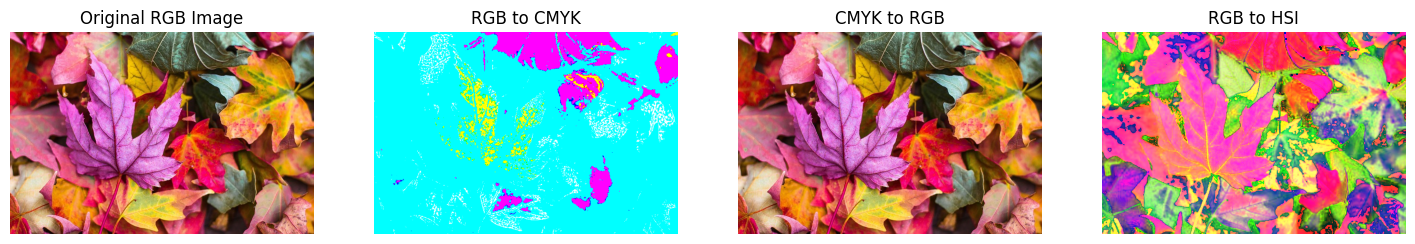

In [6]:
original_data = np.array(image1)

def process_image(image_data):
    vectorized_cmyk = np.vectorize(RGB_to_CMYK, signature='(),(),()->(),(),(),()')
    vectorized_rgb = np.vectorize(CMYK_to_RGB, signature='(),(),(),()->(),(),()')
    vectorized_hsi = np.vectorize(RGB_to_HSI, signature='(),(),()->(),(),()')

    # RGB to CMYK
    cmyk = vectorized_cmyk(image_data[...,0], image_data[...,1], image_data[...,2])
    cmyk_image = np.stack(cmyk, axis=-1)

    # CMYK to RGB
    rgb_from_cmyk = vectorized_rgb(cmyk_image[...,0], cmyk_image[...,1], cmyk_image[...,2], cmyk_image[...,3])
    rgb_from_cmyk_image = np.stack(rgb_from_cmyk, axis=-1)

    # RGB to HSI
    hsi = vectorized_hsi(image_data[...,0], image_data[...,1], image_data[...,2])
    hsi_image = np.stack(hsi, axis=-1)

    return cmyk_image, rgb_from_cmyk_image, hsi_image

cmyk_image, rgb_from_cmyk_image, hsi_image = process_image(original_data)

# Display images
plt.figure(figsize=(18, 9))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(image1)
plt.title('Original RGB Image')
plt.axis('off')

# RGB to CMYK
plt.subplot(1, 4, 2)
plt.imshow(cmyk_image)
plt.title('RGB to CMYK')
plt.axis('off')

# CMYK to RGB
plt.subplot(1, 4, 3)
plt.imshow(rgb_from_cmyk_image)
plt.title('CMYK to RGB')
plt.axis('off')

# RGB to HSI
plt.subplot(1, 4, 4)
plt.imshow(hsi_image)
plt.title('RGB to HSI')
plt.axis('off')

plt.show()


# Q2

## Read images

In [7]:
# Read images and convert them to gray scale

image1 = cv2.imread('images/2.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image1_gray = cv2.imread(('images/2.jpg'), cv2.IMREAD_GRAYSCALE)

image2 = cv2.imread('images/3.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_gray = cv2.imread(('images/3.jpg'), cv2.IMREAD_GRAYSCALE)

## Find differences between two pictures

In [8]:
def dif(image1, image2):

    # Ensure both images have the same minimum width and height
    min_width = min(image1.shape[1], image2.shape[1])
    min_height = min(image1.shape[0], image2.shape[0])
    
    # Create a result image with the same width, height, and three color channels
    result_shape = (min_height, min_width, 3)  # (Height, Width, Channels)
    result = np.zeros(result_shape, dtype=np.uint8)  # Initialize with zeros
    
    # Copy the red channel from the first image
    result[:, :, 0] = image1[:min_height, :min_width]  # Red
    
    # Copy the green channel from the second image
    result[:, :, 1] = image2[:min_height, :min_width]  # Green
    
    # Copy the blue channel from the second image
    result[:, :, 2] = image2[:min_height, :min_width]  # Blue
    
    return result


## Show result

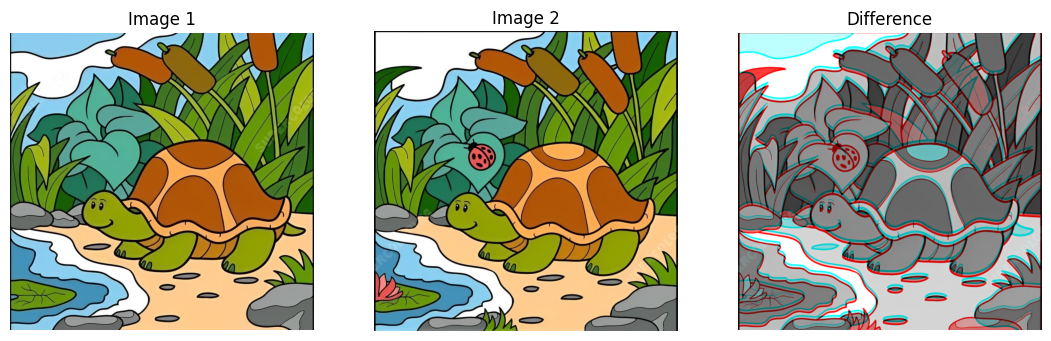

In [9]:
result = dif(image1_gray, image2_gray)

# Display images
plt.figure(figsize=(18, 9))

# Image 1
plt.subplot(1, 4, 1)
plt.imshow(image1)
plt.title('Image 1')
plt.axis('off')

# Image 2
plt.subplot(1, 4, 2)
plt.imshow(image2)
plt.title('Image 2')
plt.axis('off')

# The diffrence between them
plt.subplot(1, 4, 3)
plt.imshow(result)
plt.title('Difference')
plt.axis('off')

plt.show()